<a href="https://colab.research.google.com/github/Tomileee0300/MachineLearningProject/blob/main/GHI_and_DNI_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving ghi_dhi_2022_hourly.csv to ghi_dhi_2022_hourly.csv


/tmp/ipython-input-588656311.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range('2022-01-01 00:00:00', '2022-12-31 23:00:00', freq='H')
/tmp/ipython-input-588656311.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.set_index('date').resample('H').mean().reindex(full_range)


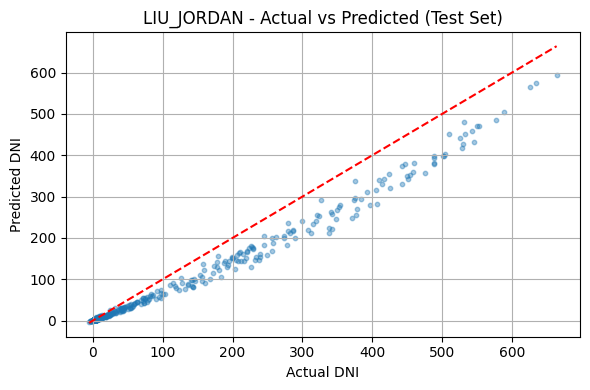

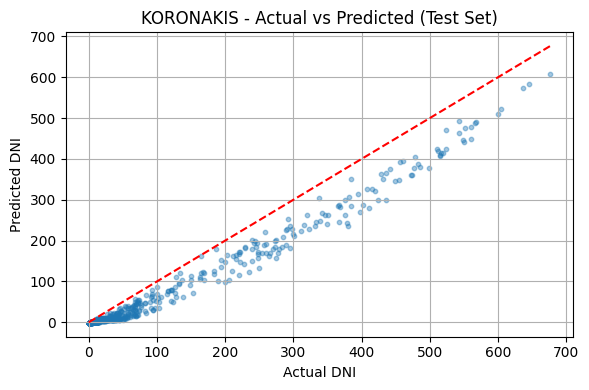

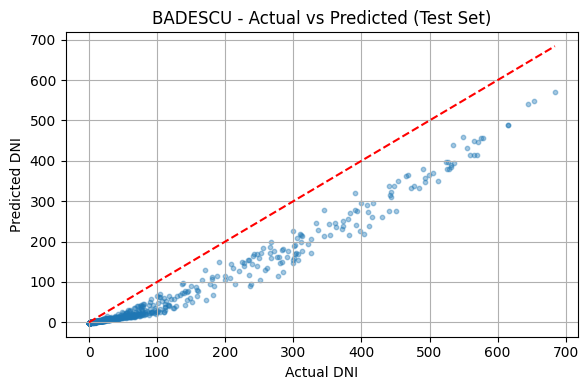

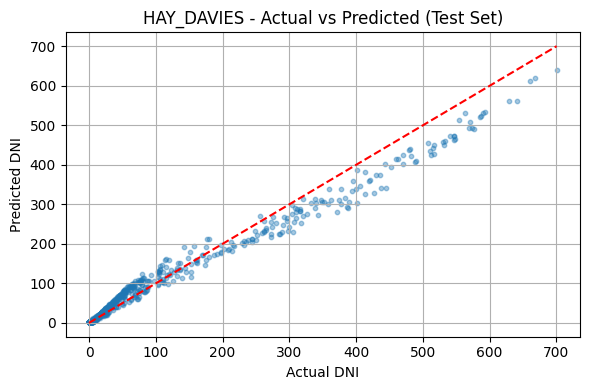

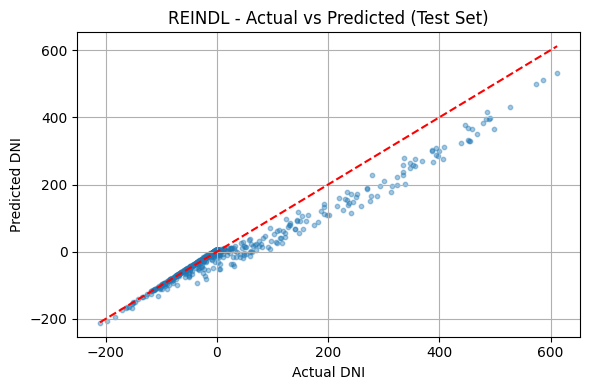

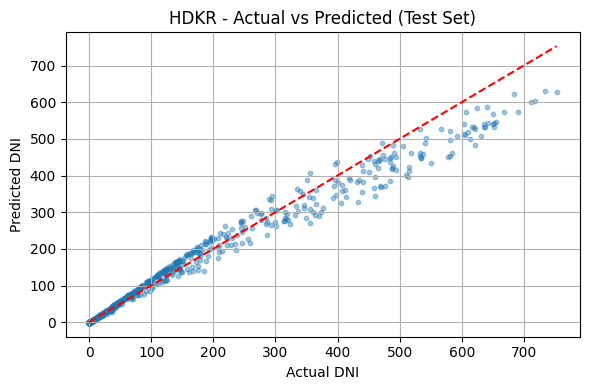

,Model,RMSE,MSE,R2,Rank
0,hay_davies,16.915338,286.128662,0.975011,1.0
1,hdkr,20.896616,436.668549,0.976590,2.0
2,liu_jordan,21.879264,478.702209,0.943660,3.0
3,reindl,23.505526,552.509766,0.912684,4.0
4,koronakis,26.507816,702.664307,0.928051,5.0
5,badescu,38.226702,1461.280762,0.863631,6.0


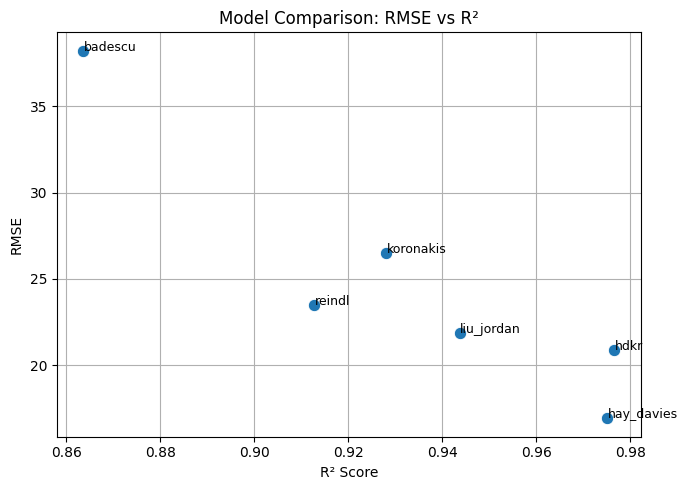

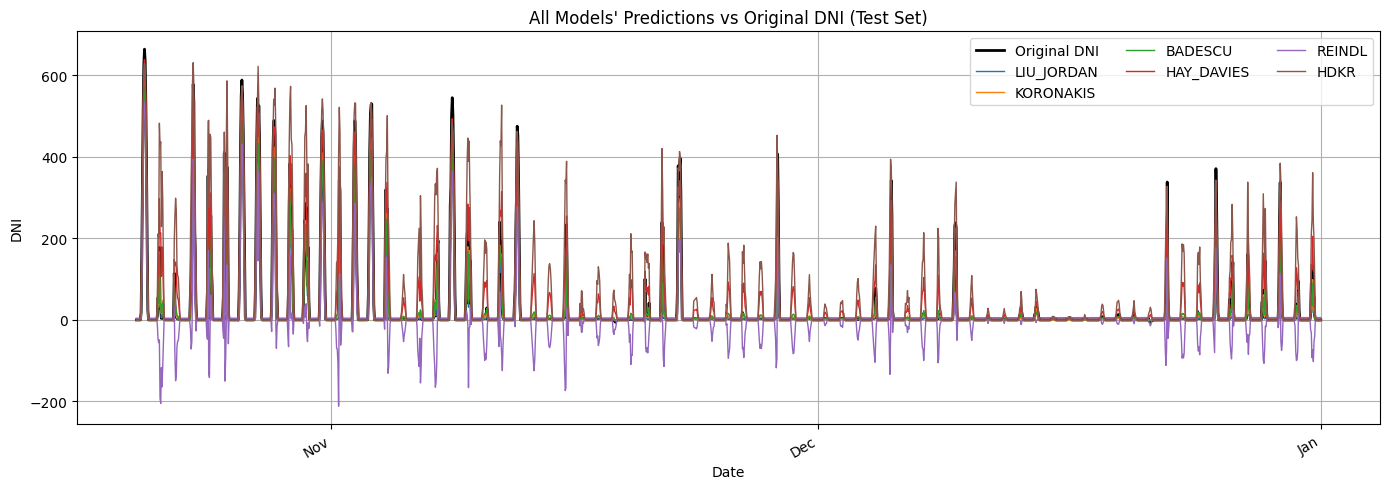

For each of the six (liu_jordan, koronakis, badescu, hay_davies, reindl, hdkr), we:

compute that model’s DNI first,

build features = [DHI, day_of_year, zenith, DNI_model],

train a separate neural net to predict GHI,

evaluate on the last 20% (chronological split),

plot per-model scatter/time-series,

compare models (RMSE vs R²),

and show a combined time-series of all six GHI predictions vs actual GHI on the test set.

It still supports manual CSV upload (date,GHI,DHI) and fills to hourly 2022.

Saving ghi_dhi_2022_hourly.csv to ghi_dhi_2022_hourly (2).csv


/tmp/ipython-input-3004034076.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range('2022-01-01 00:00:00', '2022-12-31 23:00:00', freq='H')
/tmp/ipython-input-3004034076.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H').mean(numeric_only=True)


Train span: 2022-01-01 00:00:00 → 2022-10-19 23:00:00
Test  span: 2022-10-20 00:00:00 → 2022-12-31 23:00:00


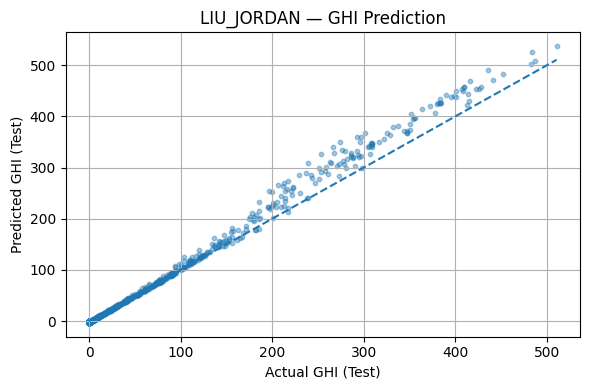

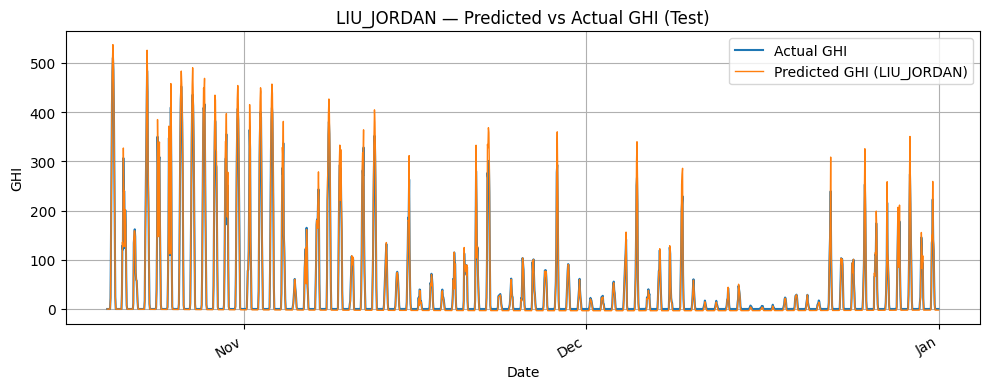

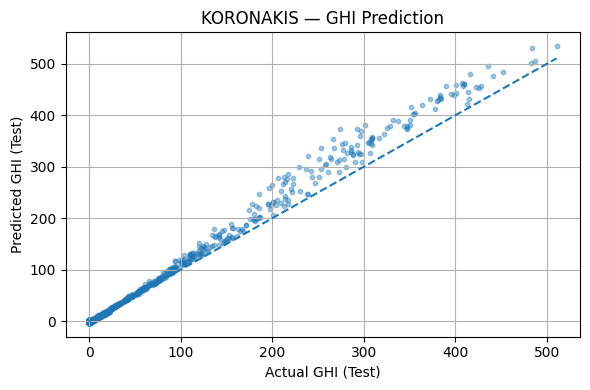

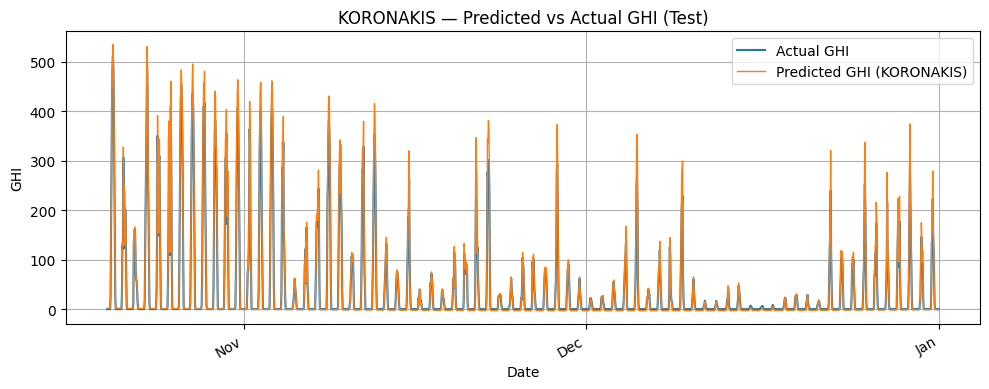

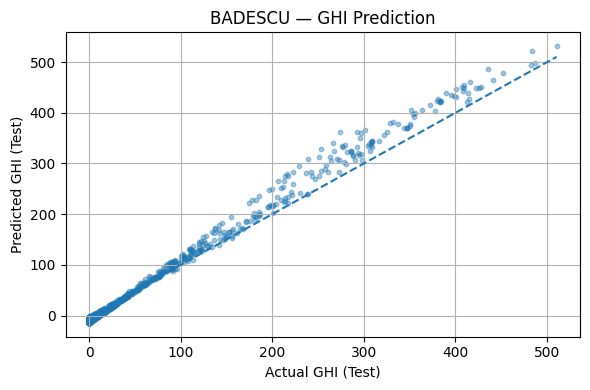

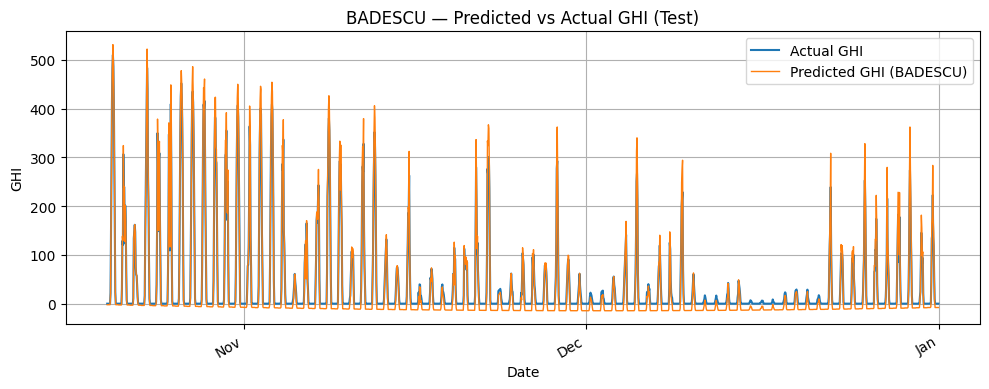

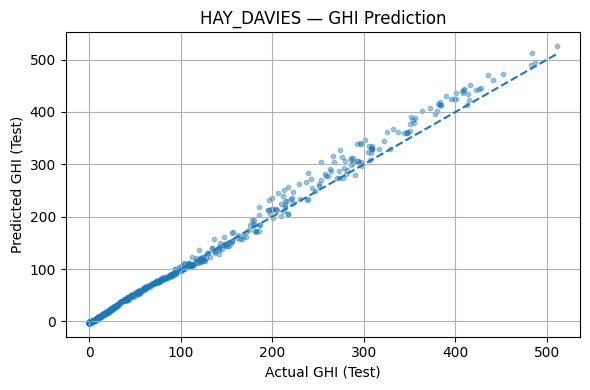

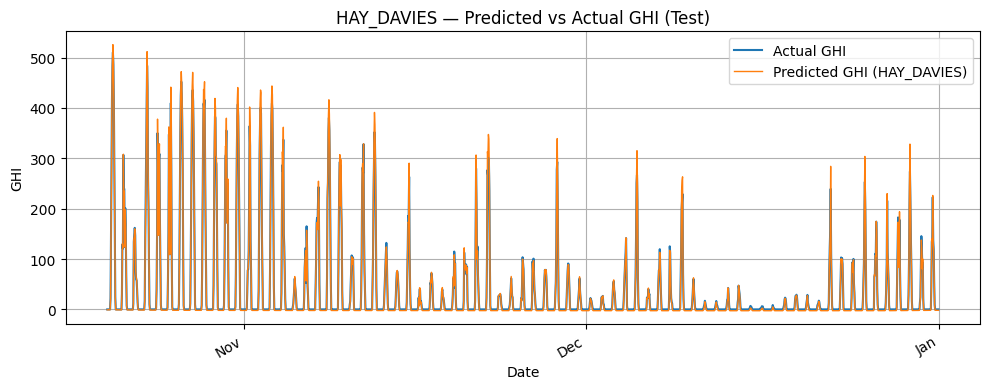

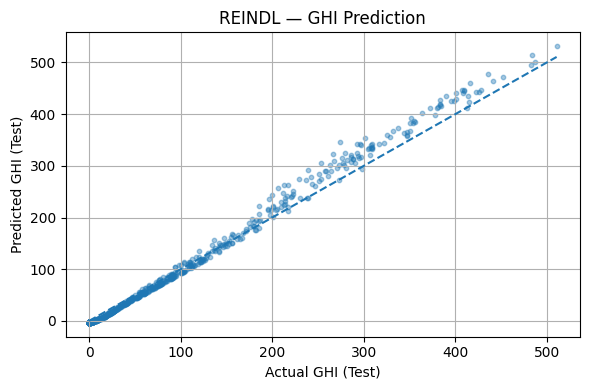

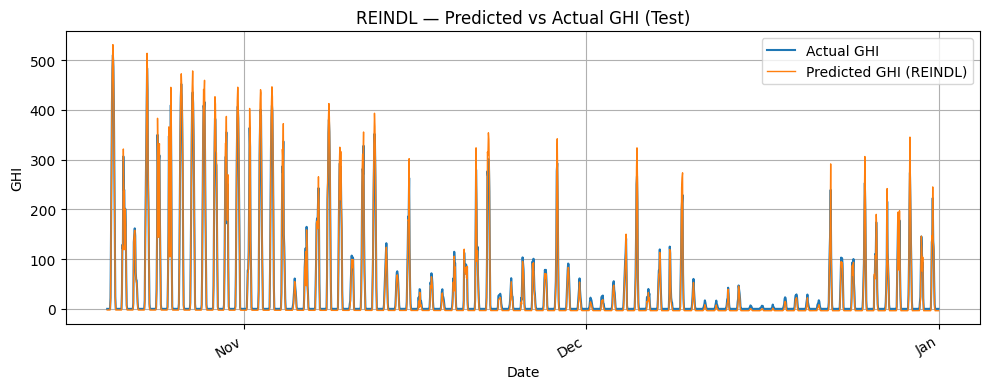

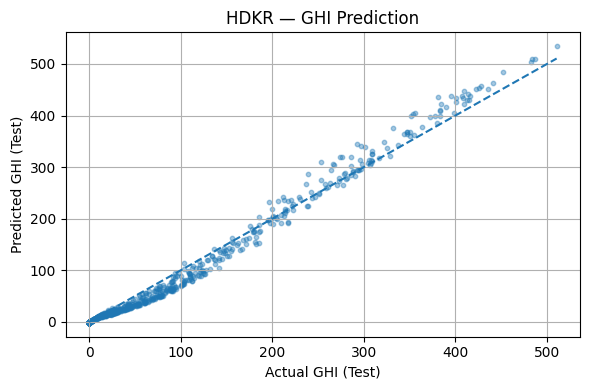

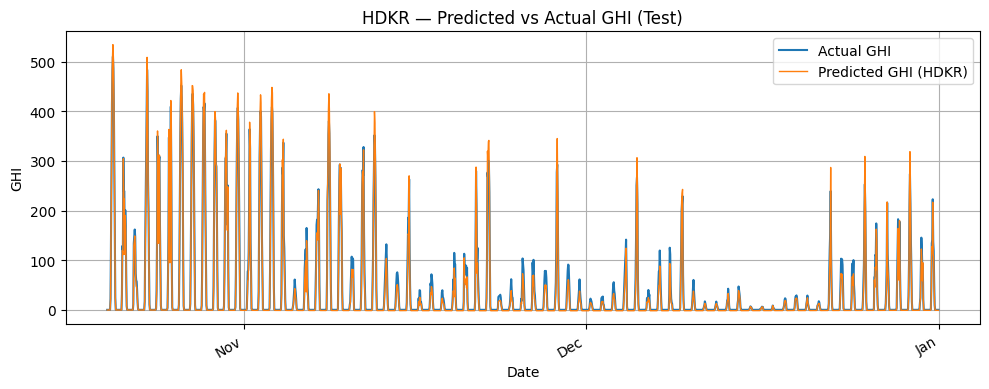

,Model,RMSE,MSE,R2
0,HAY_DAVIES,7.330741,53.739761,0.992690
1,REINDL,9.440149,89.116409,0.987879
2,HDKR,9.922543,98.456856,0.986608
3,LIU_JORDAN,11.444613,130.979172,0.982185
4,KORONAKIS,13.863639,192.200485,0.973857
5,BADESCU,15.297473,234.012695,0.968170


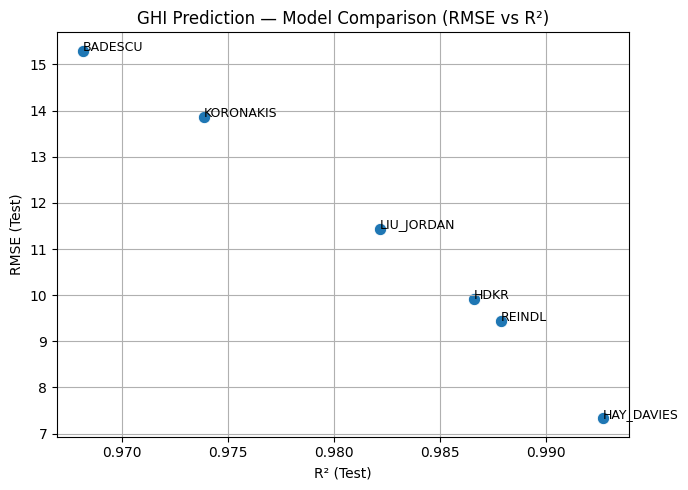

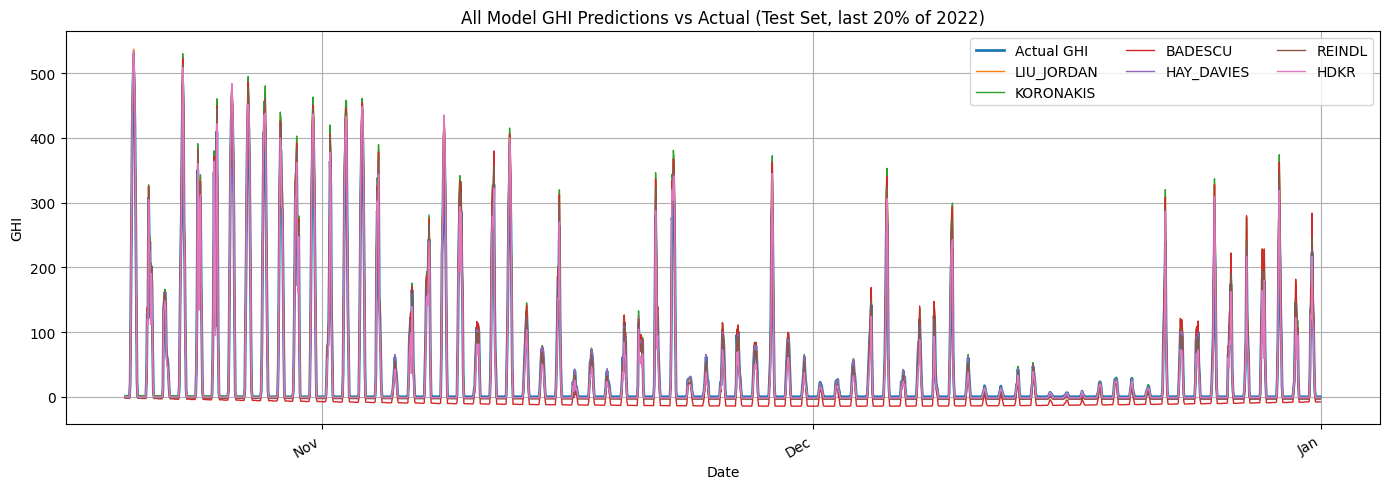

In [3]:
# 📚 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from google.colab import files

# ===============================
# 📂 Upload CSV manually (expects columns: date, GHI, DHI)
# ===============================
uploaded = files.upload()
df_raw = pd.read_csv(next(iter(uploaded)), low_memory=False)
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')
df_raw = df_raw.dropna(subset=['date']).sort_values('date')

# ===============================
# ⏱️ Resample to hourly & cover full 2022
# ===============================
full_range = pd.date_range('2022-01-01 00:00:00', '2022-12-31 23:00:00', freq='H')
df = (df_raw.set_index('date')
             .resample('H').mean(numeric_only=True)
             .reindex(full_range))

for col in ['GHI', 'DHI']:
    if col not in df.columns:
        df[col] = 0.0
    df[col] = df[col].fillna(0.0)

df = df.reset_index().rename(columns={'index':'date'})
df['ghi'] = df['GHI'].astype(float)
df['dhi'] = df['DHI'].astype(float)
df['day_of_year'] = df['date'].dt.dayofyear

# ===============================
# ☀️ Solar zenith angle (simple noon HA=0 approximation)
# ===============================
def solar_zenith_angle(day_of_year, lat=35):
    decl = 23.45 * np.sin(np.radians(360 * (284 + day_of_year) / 365.0))
    ha = 0.0
    zenith = np.arccos(
        np.sin(np.radians(lat)) * np.sin(np.radians(decl)) +
        np.cos(np.radians(lat)) * np.cos(np.radians(decl)) * np.cos(np.radians(ha))
    )
    return np.degrees(zenith)

df['zenith'] = df['day_of_year'].apply(solar_zenith_angle)

# ===============================
# 🧮 Compute six DNI variants (used as features)
# ===============================
def compute_dni_models(row):
    dhi, ghi, zen = row['dhi'], row['ghi'], row['zenith']
    cos_z = max(np.cos(np.radians(zen)), 1e-6)
    return pd.Series({
        'liu_jordan': (ghi - dhi) / cos_z,
        'koronakis':  (ghi - dhi * (1 + np.cos(np.radians(zen))) / 2) / cos_z,
        'badescu':    (ghi - dhi * (1 + np.cos(np.radians(zen))**2) / 2) / cos_z,
        'hay_davies': (ghi - dhi) / cos_z + dhi * np.cos(np.radians(zen)),
        'reindl':     (ghi - dhi * (1 + np.cos(np.radians(zen)))) / cos_z,
        'hdkr':       ((ghi - dhi) / cos_z) + dhi * (1 + np.cos(np.radians(zen))),
    })

model_names = ['liu_jordan','koronakis','badescu','hay_davies','reindl','hdkr']
dni_df = df.apply(compute_dni_models, axis=1)
df = pd.concat([df, dni_df], axis=1)

# ===============================
# 🧠 NN for GHI (per-model)
# ===============================
class GHINet(nn.Module):
    def __init__(self, in_features=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
    def forward(self, x):
        return self.net(x)

# ===============================
# 🔁 80/20 chronological split
# ===============================
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()
dates_test = test_df['date'].values

print(f"Train span: {train_df['date'].iloc[0]} → {train_df['date'].iloc[-1]}")
print(f"Test  span: {test_df['date'].iloc[0]} → {test_df['date'].iloc[-1]}")

# Target
y_train_full = train_df['ghi'].values.astype(np.float32)
y_test_full  = test_df['ghi'].values.astype(np.float32)

results = {}

# ===============================
# 🚂 Train & evaluate each model (features: DHI, DOY, ZENITH, DNI_model)
# ===============================
for name in model_names:
    # Features include the model-specific DNI
    X_train = train_df[['dhi','day_of_year','zenith', name]].values.astype(np.float32)
    X_test  = test_df[['dhi','day_of_year','zenith', name]].values.astype(np.float32)

    X_train_t = torch.tensor(X_train)
    X_test_t  = torch.tensor(X_test)
    y_train_t = torch.tensor(y_train_full).view(-1,1)

    ds   = TensorDataset(X_train_t, y_train_t)
    dl   = DataLoader(ds, batch_size=32, shuffle=True)
    net  = GHINet(in_features=4)
    loss = nn.MSELoss()
    opt  = torch.optim.Adam(net.parameters(), lr=1e-3)

    # Train
    for epoch in range(100):
        for xb, yb in dl:
            pred = net(xb)
            l = loss(pred, yb)
            opt.zero_grad()
            l.backward()
            opt.step()

    # Predict on test
    net.eval()
    with torch.no_grad():
        y_pred_test = net(X_test_t).numpy().flatten()

    # Metrics
    mse  = mean_squared_error(y_test_full, y_pred_test)
    rmse = float(np.sqrt(mse))
    r2   = float(r2_score(y_test_full, y_pred_test))

    results[name] = {
        'rmse': rmse, 'mse': mse, 'r2': r2,
        'preds': y_pred_test
    }

    # Scatter: Actual vs Predicted (test)
    plt.figure(figsize=(6,4))
    plt.scatter(y_test_full, y_pred_test, alpha=0.4, s=10)
    plt.plot([y_test_full.min(), y_test_full.max()],
             [y_test_full.min(), y_test_full.max()],
             linestyle='--')
    plt.xlabel("Actual GHI (Test)")
    plt.ylabel("Predicted GHI (Test)")
    plt.title(f"{name.upper()} — GHI Prediction")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Time series (test)
    plt.figure(figsize=(10,4))
    plt.plot(dates_test, y_test_full, label="Actual GHI", linewidth=1.5)
    plt.plot(dates_test, y_pred_test, label=f"Predicted GHI ({name.upper()})", linewidth=1)
    plt.xlabel("Date"); plt.ylabel("GHI")
    plt.title(f"{name.upper()} — Predicted vs Actual GHI (Test)")
    plt.legend(); plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout(); plt.show()

# ===============================
# 📋 Results table + RMSE vs R²
# ===============================
results_df = pd.DataFrame([
    {'Model': k.upper(), 'RMSE': v['rmse'], 'MSE': v['mse'], 'R2': v['r2']}
    for k, v in results.items()
]).sort_values('RMSE').reset_index(drop=True)

try:
    from IPython.display import display
    display(results_df)
except:
    print(results_df)

plt.figure(figsize=(7,5))
sns.scatterplot(x='R2', y='RMSE', data=results_df, s=80)
for _, row in results_df.iterrows():
    plt.text(row['R2'] + 1e-6, row['RMSE'] + 1e-5, row['Model'], fontsize=9)
plt.xlabel("R² (Test)"); plt.ylabel("RMSE (Test)")
plt.title("GHI Prediction — Model Comparison (RMSE vs R²)")
plt.grid(True); plt.tight_layout(); plt.show()

# ===============================
# 👥 Combined time-series: all six GHI predictions vs Actual (test)
# ===============================
plt.figure(figsize=(14,5))
plt.plot(dates_test, y_test_full, label="Actual GHI", linewidth=2)
for name in model_names:
    plt.plot(dates_test, results[name]['preds'], label=name.upper(), linewidth=1)
plt.xlabel("Date"); plt.ylabel("GHI")
plt.title("All Model GHI Predictions vs Actual (Test Set, last 20% of 2022)")
plt.legend(ncol=3); plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gcf().autofmt_xdate()
plt.tight_layout(); plt.show()


Saving ghi_dhi_2022_hourly.csv to ghi_dhi_2022_hourly (1).csv


/tmp/ipython-input-588656311.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range('2022-01-01 00:00:00', '2022-12-31 23:00:00', freq='H')
/tmp/ipython-input-588656311.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_raw.set_index('date').resample('H').mean().reindex(full_range)


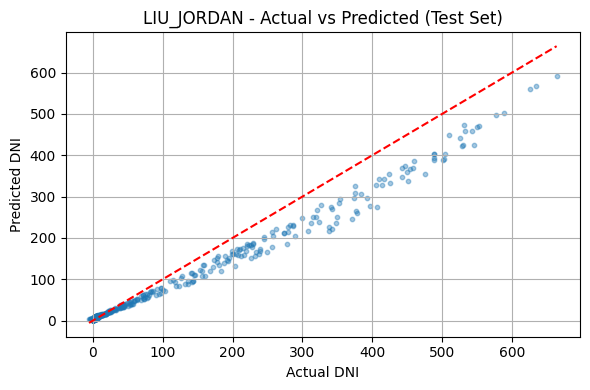

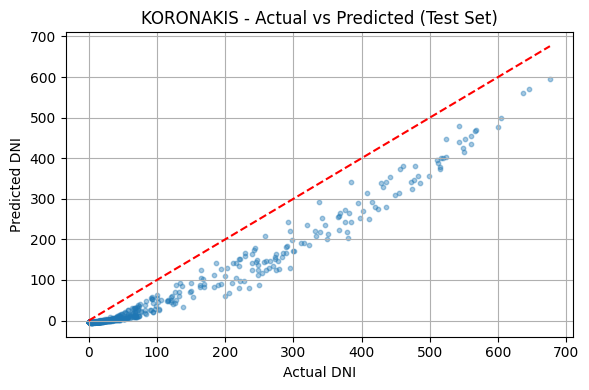

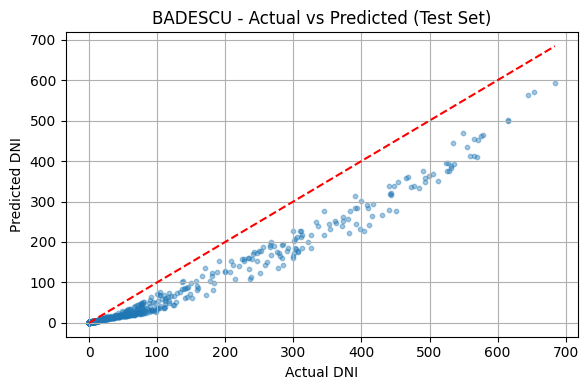

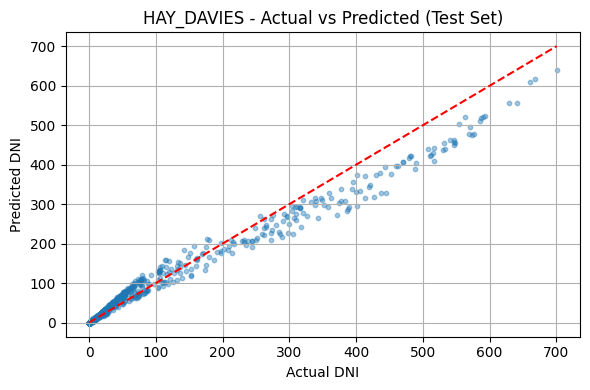

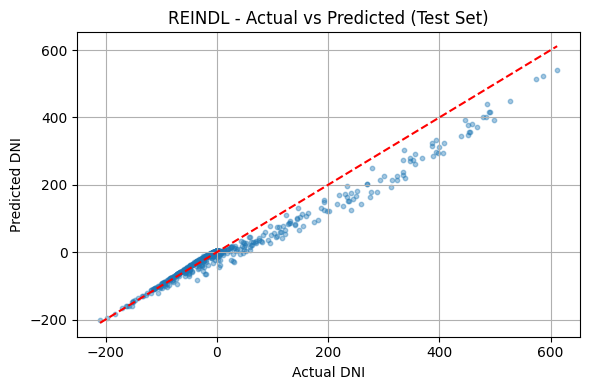

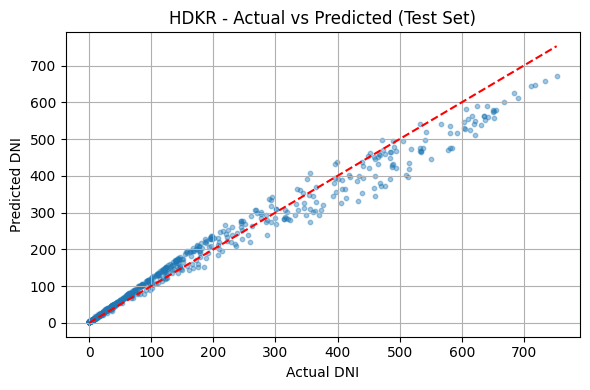

,Model,RMSE,MSE,R2,Rank
0,hay_davies,18.185900,330.726959,0.971116,1.0
1,hdkr,18.733924,350.959900,0.981185,2.0
2,reindl,19.657327,386.410522,0.938934,3.0
3,liu_jordan,20.313519,412.639069,0.951435,4.0
4,badescu,35.301341,1246.184692,0.883704,5.0
5,koronakis,35.830353,1283.814209,0.868545,6.0


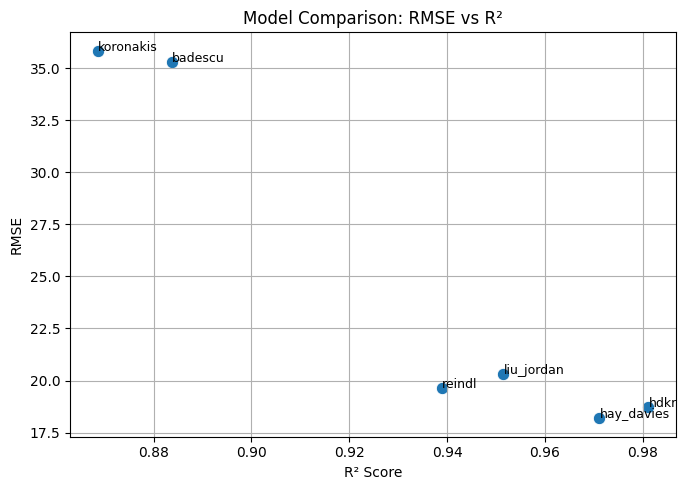

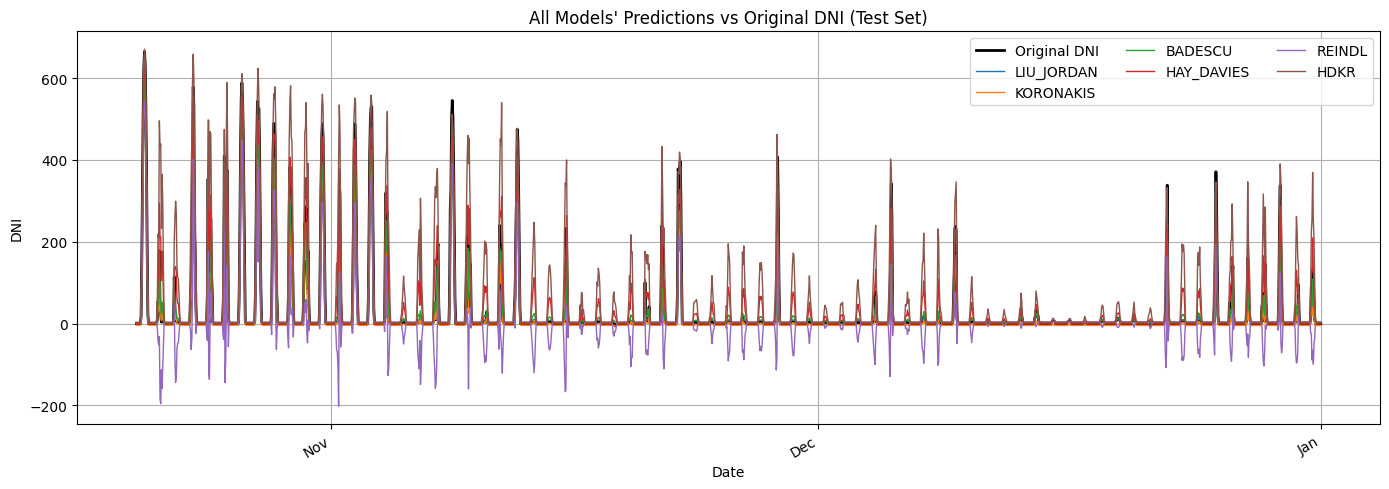

In [2]:
# 📚 Import packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from google.colab import files

# 📂 Upload your CSV file manually
uploaded = files.upload()
df_raw = pd.read_csv(next(iter(uploaded)))
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw = df_raw.sort_values('date')

# 🕒 Resample to hourly & fill full 2022 range
full_range = pd.date_range('2022-01-01 00:00:00', '2022-12-31 23:00:00', freq='H')
df = df_raw.set_index('date').resample('H').mean().reindex(full_range)
for col in ['GHI', 'DHI']:
    if col not in df.columns:
        df[col] = 0.0
    df[col] = df[col].fillna(0.0)
df = df.reset_index().rename(columns={'index':'date'})

# 🌞 Feature engineering
df['day_of_year'] = df['date'].dt.dayofyear
df['ghi'] = df['GHI']
df['dhi'] = df['DHI']

# ☀️ Solar zenith angle
def solar_zenith_angle(day_of_year, lat=35):
    decl = 23.45 * np.sin(np.radians(360 * (284 + day_of_year) / 365))
    ha = 0
    zenith = np.arccos(
        np.sin(np.radians(lat)) * np.sin(np.radians(decl)) +
        np.cos(np.radians(lat)) * np.cos(np.radians(decl)) * np.cos(np.radians(ha))
    )
    return np.degrees(zenith)

df['zenith'] = df['day_of_year'].apply(solar_zenith_angle)

# 🧮 Compute DNI for each model
def compute_dni_models(row):
    dhi, ghi, zenith = row['dhi'], row['ghi'], row['zenith']
    cos_z = np.cos(np.radians(zenith))
    dni = {}
    dni['liu_jordan'] = (ghi - dhi) / max(cos_z, 1e-6)
    dni['koronakis'] = (ghi - dhi * (1 + np.cos(np.radians(zenith))) / 2) / max(cos_z, 1e-6)
    dni['badescu'] = (ghi - dhi * (1 + np.cos(np.radians(zenith))**2) / 2) / max(cos_z, 1e-6)
    dni['hay_davies'] = (ghi - dhi) / max(cos_z, 1e-6) + dhi * cos_z
    dni['reindl'] = (ghi - dhi * (1 + np.cos(np.radians(zenith)))) / max(cos_z, 1e-6)
    dni['hdkr'] = ((ghi - dhi) / max(cos_z, 1e-6)) + dhi * (1 + np.cos(np.radians(zenith)))
    return pd.Series(dni)

dni_df = df.apply(compute_dni_models, axis=1)
df = pd.concat([df, dni_df], axis=1)

# 📊 Train-test split (80% train / 20% test)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]
dates_test = test_df['date']

# 🧠 Define neural network model
class SolarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

features_train = train_df[['ghi', 'dhi', 'day_of_year']].values.astype(np.float32)
features_test = test_df[['ghi', 'dhi', 'day_of_year']].values.astype(np.float32)
X_train_tensor = torch.tensor(features_train)
X_test_tensor = torch.tensor(features_test)

model_names = ['liu_jordan', 'koronakis', 'badescu', 'hay_davies', 'reindl', 'hdkr']
results = {}

for model_name in model_names:
    y_train = train_df[model_name].values.astype(np.float32)
    y_test = test_df[model_name].values.astype(np.float32)
    y_train_tensor = torch.tensor(y_train).view(-1, 1)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = SolarNet()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    for epoch in range(100):
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Predict
    model.eval()
    with torch.no_grad():
        y_pred_test_tensor = model(X_test_tensor)
        y_pred_test = y_pred_test_tensor.numpy().flatten()

    # Evaluate
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    results[model_name] = {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'preds': y_pred_test
    }

    # Scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred_test, alpha=0.4, s=10)
    plt.xlabel("Actual DNI")
    plt.ylabel("Predicted DNI")
    plt.title(f"{model_name.upper()} - Actual vs Predicted (Test Set)")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📋 Results table
results_df = pd.DataFrame([
    {'Model': k, 'RMSE': v['rmse'], 'MSE': v['mse'], 'R2': v['r2']}
    for k, v in results.items()
])
results_df['Rank'] = results_df['RMSE'].rank(method='min')
results_df = results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
display(results_df)

# 📊 RMSE vs R²
plt.figure(figsize=(7, 5))
sns.scatterplot(x='R2', y='RMSE', data=results_df, s=80)
for i, row in results_df.iterrows():
    plt.text(row['R2'] + 0.0001, row['RMSE'] + 0.0001, row['Model'], fontsize=9)
plt.xlabel("R² Score")
plt.ylabel("RMSE")
plt.title("Model Comparison: RMSE vs R²")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Combined time-series plot for test set
cos_z_test = np.cos(np.radians(test_df['zenith']))
cos_z_test = np.where(cos_z_test <= 0, 1e-6, cos_z_test)
dni_original_test = (test_df['ghi'] - test_df['dhi']) / cos_z_test

plt.figure(figsize=(14, 5))
plt.plot(dates_test, dni_original_test, label="Original DNI", linewidth=2, color='black')
for m in model_names:
    plt.plot(dates_test, results[m]['preds'], label=m.upper(), linewidth=1)
plt.xlabel("Date")
plt.ylabel("DNI")
plt.title("All Models' Predictions vs Original DNI (Test Set)")
plt.legend(ncol=3)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
